In [162]:
import numpy as np
import matplotlib.pyplot as plt
import gdal
import cv2

gdal.AllRegister()
plt.rcParams['figure.figsize'] = [10, 5]

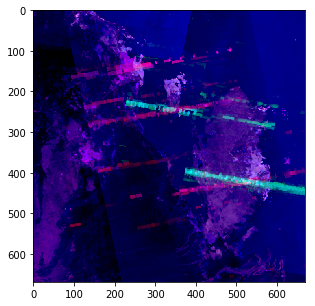

In [163]:
# Load data from tif file
ds = gdal.Open('./vhExportSmallMax.tif')
vh_band = ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
vh1_band = ds.GetRasterBand(2)
vh1 = vh1_band.ReadAsArray()
vv_band = ds.GetRasterBand(3)
vv = vv_band.ReadAsArray()

# Strip NaNs (I think these appear where data is redacted)
vh[np.isnan(vh)]=np.median(vh[np.isfinite(vh)])-np.std(vh[np.isfinite(vh)])
vh1[np.isnan(vh1)]=np.median(vh1[np.isfinite(vh1)])-np.std(vh1[np.isfinite(vh1)])
vv[np.isnan(vv)]=np.median(vv[np.isfinite(vv)])-np.std(vv[np.isfinite(vv)])

# Apply the upper and lower cutoffs that Harel Dan applied
vh[vh < -25] = -25
vh[vh > 0] = 0
vh1[vh1 < -20] = -20
vh1[vh1 > 10] = 10
vv[vv < -25] = -25
vv[vv > 0] = 0

# Scale to [0, 255]
vh = vh - np.min(vh)
vh = vh / np.max(vh) * 255
vh1 = vh1 - np.min(vh1)
vh1 = vh1 / np.max(vh1) * 255
vv = vv - np.min(vv)
vv = vv / np.max(vv) * 255

# Plot
img = np.zeros([vh.shape[0],vh.shape[1],3])
img[:,:,0] = vh
img[:,:,1] = vh1
img[:,:,2] = vv
r,g,b = cv2.split(img)
rgb = cv2.merge([r, g, b])
rgb = rgb.astype(np.uint8)
plt.imshow(rgb)
plt.savefig('img.png', dpi=600)

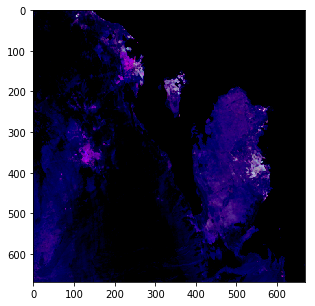

In [166]:
# Load data from tif file
ds = gdal.Open('./vhExportSmallMin.tif')
vh_band = ds.GetRasterBand(1)
vh = vh_band.ReadAsArray()
vh1_band = ds.GetRasterBand(2)
vh1 = vh1_band.ReadAsArray()
vv_band = ds.GetRasterBand(3)
vv = vv_band.ReadAsArray()

# Strip NaNs (I think these appear where data is redacted)
vh[np.isnan(vh)]=np.median(vh[np.isfinite(vh)])-np.std(vh[np.isfinite(vh)])
vh1[np.isnan(vh1)]=np.median(vh1[np.isfinite(vh1)])-np.std(vh1[np.isfinite(vh1)])
vv[np.isnan(vv)]=np.median(vv[np.isfinite(vv)])-np.std(vv[np.isfinite(vv)])

# Apply the upper and lower cutoffs that Harel Dan applied
vh[vh < -25] = -25
vh[vh > 0] = 0
vh1[vh1 < -20] = -20
vh1[vh1 > 10] = 10
vv[vv < -25] = -25
vv[vv > 0] = 0

# Scale to [0, 255]
vh = vh - np.min(vh)
vh = vh / np.max(vh) * 255
vh1 = vh1 - np.min(vh1)
vh1 = vh1 / np.max(vh1) * 255
vv = vv - np.min(vv)
vv = vv / np.max(vv) * 255

# Plot
img = np.zeros([vh.shape[0],vh.shape[1],3])
img[:,:,0] = vh
img[:,:,1] = vh1
img[:,:,2] = vv
r,g,b = cv2.split(img)
rgb = cv2.merge([r, g, b])
rgb = rgb.astype(np.uint8)
plt.imshow(rgb)
plt.savefig('img.png', dpi=600)

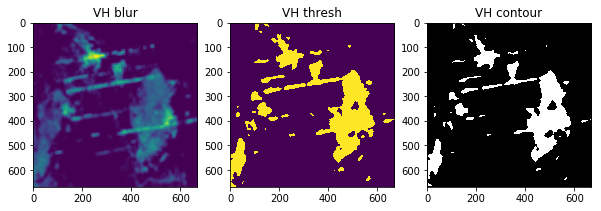

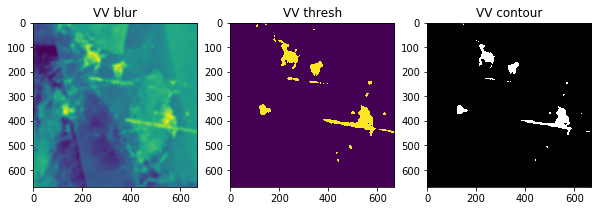

In [164]:
def processing_chain(raw, polarization_name, blur_val=15, thresh_val=110):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    # Force the scalar field to [0, 255]
    shifted = raw - np.min(raw)
    scaled = shifted / np.max(shifted) * 255
    scaled = scaled.astype(np.uint8)
    
    # Trick OpenCV into believing that this array is an image
    img = np.zeros([scaled.shape[0],scaled.shape[1],3])
    img[:,:,0] = scaled
    img[:,:,1] = scaled
    img[:,:,2] = scaled
    r,g,b = cv2.split(img)
    bgr = cv2.merge([b,g,r])
    bgr = bgr.astype(np.uint8)
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
    
    # Blur
    blured = cv2.blur(gray,(blur_val, blur_val))
    ax1.imshow(blured)
    ax1.set_title(polarization_name + ' blur')
    
    # Threshold
    thresh_val = np.mean(blured) + thresh_val * np.std(blured)
    (ret, thresh) = cv2.threshold(blured, thresh_val, 1, 0)
    ax2.imshow(thresh)
    ax2.set_title(polarization_name + ' thresh')
    
    # Get contours
    im, contours, hier = cv2.findContours(thresh, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(thresh, contours, -1, (0,255,0), 3)
    ax3.imshow(thresh,cmap='gray')
    ax3.set_title(polarization_name + ' contour')
    plt.show()

    return thresh

vht = processing_chain(vh, 'VH', thresh_val=1.)
vvt = processing_chain(vv, 'VV', thresh_val=1.5)

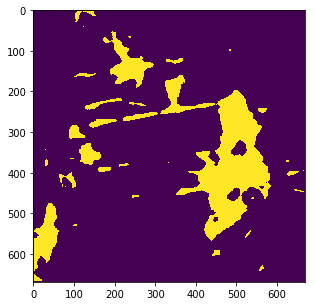

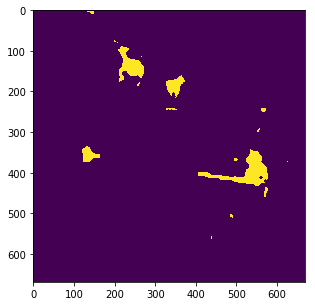

In [165]:
intersection = np.logical_and(vht, vvt)
union = np.logical_or(vht, vvt)

plt.imshow(union)
plt.show()

plt.imshow(intersection)
plt.show()